<a href="https://colab.research.google.com/github/Pmilivojevic/COVID_detection/blob/main/Comparative_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ucitavanje potrebnih biblioteka

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import re
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Putanje do test snimaka i treniranih modela

testPath= '/content/drive/My Drive/Colab Notebooks/covidDetection/Test'
testAugmentedPath= '/content/drive/My Drive/Colab Notebooks/covidDetection/TestAugmented'
tl_modelsPath= '/content/drive/My Drive/Colab Notebooks/covidDetection/covidModels/transferLearning'
ft_modelsPath= '/content/drive/My Drive/Colab Notebooks/covidDetection/covidModels/fineTuning'

In [ ]:
# Ucitavanje test seta podataka

TestImagePaths = list(paths.list_images(testPath))
dataTest = []
labelsTest = []

for TestImagePath in TestImagePaths:
	labelTest = TestImagePath.split(os.path.sep)[-2]
	image = cv2.imread(TestImagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))
	dataTest.append(image)
	labelsTest.append(labelTest)
# Slike se normalizuju na opseg (-1.0, 1.0)
dataTest = np.array(dataTest)
dataTest= (dataTest-127.5)/127.5
labelsTest = np.array(labelsTest)

lbTest = LabelBinarizer()
labelsTest1 = lbTest.fit_transform(labelsTest)
labelsTest2 = to_categorical(labelsTest1)
labelsTest3 = np.argmax(labelsTest2, axis=1)

In [ ]:
# Ucitavanje modela i racunanje osnovne metrike za uporednu analizu modela

modelsPath = ft_modelsPath
pattern = "(.h5)"
newPattern = r""
names  = []
cms = []
accs = []
precs = []
recalls = []
f1s = []

for name in os.listdir(modelsPath):
  modelName = re.sub(pattern, newPattern, name)
  names.append(modelName)
  model = load_model(modelsPath+'/'+name)
  predIdxs = model.predict(dataTest)
  predIdxs = np.argmax(predIdxs, axis=1)
  cm = confusion_matrix(labelsTest, predIdxs)
  cms.append(cm)
  acc = (cm[0,0] + cm[1,1]) / sum(sum(cm))
  accs.append(acc)
  precission = cm[1,1] / (cm[1,1] + cm[0,1])
  precs.append(precission)
  recall = cm[1,1] / (cm[1,1] + cm[1,0])
  recalls.append(recall)
  f1 = 2 * precission * recall / (precission + recall)
  f1s.append(f1)

ValueError: ignored

In [ ]:
# Tabelarni prikaz modela i odgovarajucih parametara

print(format('Model:', '30'), format('Precission:', '12'), format('Recall:', '8'), format('Accuracy:', '10'), format('F1 score:', '10'))
for i in range(len(os.listdir(modelsPath))):
  print(format(names[i], '30'), format(precs[i], '<12.4f'), format(recalls[i], '<8.4f'), format(accs[i], '<10.4f'), format(f1s[i], '<10.4f'))

Model:                         Precission:  Recall:  Accuracy:  F1 score: 
ResNet152V2_fineTuned          1.0000       1.0000   1.0000     1.0000    
ResNet50V2_fineTuned           0.9524       1.0000   0.9750     0.9756    
InceptionResNetV2_fineTuned    0.9524       1.0000   0.9750     0.9756    


Iz tablice se vidi da najbolje performanse daju mreze ResNet50V2, ResNet152V2 i InceptionResNetV2, pa je plan primeniti korak fine-tuning na sve tri mreze i videti koja daje najbolji rezultat

In [ ]:
# funkcija za plot konfuzione matrice

def plot_confusion_matrix(cm, classes, ax, title, cmap= plt.cm.Blues):
  ax.imshow(cm, interpolation= 'nearest', cmap= cmap)
  ax.set_title(title)
  tick_marks= np.arange(len(classes))
  ax.set_xticks(tick_marks)
  ax.set_xticklabels(classes)
  ax.set_yticks(tick_marks)
  ax.set_yticklabels(classes)

  thresh= cm.max()/2.
  for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, cm[i,j], horizontalalignment= 'center', color= 'white' if cm[i,j] > thresh else 'black')

  plt.tight_layout()
  ax.set_xlabel('Predicted label')
  ax.set_ylabel('True label')

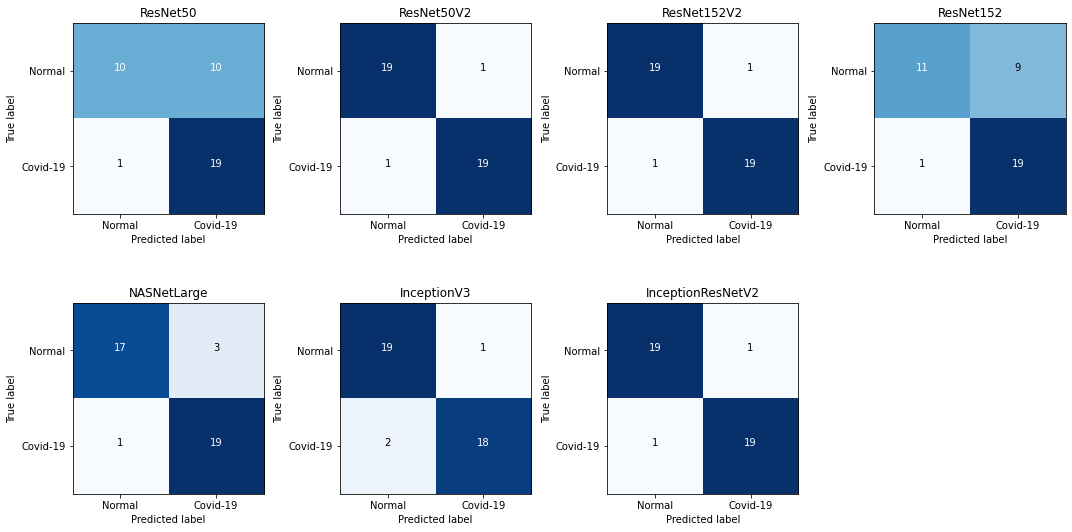

In [ ]:
# Plot konfuzionih matrica modela iz transfer learning koraka

fig= plt.figure(figsize= (15,8))
axs= []
labels= ['Normal', 'Covid-19']

ax1= plt.subplot2grid((2,4), (0,0))
axs.append(ax1)
ax2= plt.subplot2grid((2,4), (0,1))
axs.append(ax2)
ax3= plt.subplot2grid((2,4), (0,2))
axs.append(ax3)
ax4= plt.subplot2grid((2,4), (0,3))
axs.append(ax4)
ax5= plt.subplot2grid((2,4), (1,0))
axs.append(ax5)
ax6= plt.subplot2grid((2,4), (1,1))
axs.append(ax6)
ax7= plt.subplot2grid((2,4), (1,2))
axs.append(ax7)

for i in range(len(cms)):
  plot_confusion_matrix(cms[i], labels, axs[i], names[i])

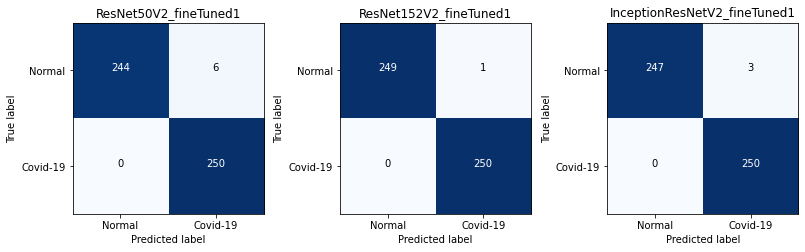

In [ ]:
# Plot konfuzione matrice iz fine-tuning koraka

fig= plt.figure(figsize= (15,10))
axs= []
labels= ['Normal', 'Covid-19']

ax1= plt.subplot2grid((2,4), (0,0))
axs.append(ax1)
ax2= plt.subplot2grid((2,4), (0,1))
axs.append(ax2)
ax3= plt.subplot2grid((2,4), (0,2))
axs.append(ax3)

for i in range(len(cms)):
  plot_confusion_matrix(cms[i], labels, axs[i], names[i])

Kada se odradi uporedna analiza modela koji su prosli kroz fine-tuning korak, na osnovu tabele i konfuzionih matrica, vidimo da najbolje performanse daje ResNet152V2_fineTuned.